In [1]:
%matplotlib inline

import sys
sys.path.insert(0, "../fl_sim/")

In [2]:
import glob
import torch
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (5,3)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from models import *
from models.gan import ResNetDiscriminator, StyleVectorizer
from data_funcs import *
from utils.logger import Logger
import utils.gan_utils as gan_utils

## Init trainer and worker just like run_gan.py and load

In [3]:
RUN_PADPAF = "../outputs/id=padpaf/task=damnist-fedgan/lr=0.001_0.01/seed=123/model/model_round*.pth.tar"
RUN_PADPAF_COND = "../outputs/id=padpaf/task=damnist-fedgan-conditional-partial/lr=0.001_0.01/seed=123/model/model_round*.pth.tar"
RUN_PADPAF_UNSEEN_COND = "../outputs/id=padpaf/task=damnist-fedgan-unseen-conditional-partial/lr=0.001_0.01/seed=123/model/*"

MODEL_PATHS = RUN_PADPAF_UNSEEN_COND

In [4]:
conditional = 'conditional' in MODEL_PATHS
unseen = 'unseen' in MODEL_PATHS

In [5]:
# model_paths = glob.glob("models/partial/normal/model_round*.pth.tar")
def get_round(model_path):
    return int(model_path[-11:-8])

model_paths = glob.glob(MODEL_PATHS)
# model_paths = sorted(model_paths, key=lambda pth: get_round(pth))  # sort by round
for p in model_paths: print(p)

In [6]:
Logger.setup_logging("INFO", logfile="")
Logger()

image_size = 32
channels = 3
seed = 123
dataset_name = "damnist"
data_path = "../data/"
num_workers = 0
batch_size = 32
device = "cuda:0" if torch.cuda.is_available() else "cpu"
num_classes = 10

In [7]:
loader_kwargs = {}
if not device == 'cpu':
    loader_kwargs["num_workers"] = num_workers
    loader_kwargs["persistent_workers"] = num_workers > 0
train_loader_kwargs = {'batch_size': batch_size, 'shuffle': True, **loader_kwargs}

In [8]:
def init_styleD(num_features=64):
     return ResNetDiscriminator(num_features=num_features, image_size=image_size, channels=channels)


def init_style_map(num_latents=128):
     return StyleVectorizer(num_latents, 8, lr_mul=0.1)

    
def init_model(num_latents=128, num_features=64):
    return FedGAN(num_latents=num_latents,
                             D_features=num_features, G_features=num_features,
                             image_size=image_size, channels=channels, num_classes=num_classes if conditional else 0)

In [9]:
def load_fedgan_one_style(global_model, fp, style_id=0, device=None):
    state_dict = torch.load(fp, map_location=device)
    # Global modules
    global_model.contentD.load_state_dict(state_dict['contentD'])
    global_model.G.load_state_dict(state_dict['G'])
    # Local modules
    local_state_dict = state_dict[str(style_id)]
    global_model.styleD.load_state_dict(local_state_dict['styleD'])
    global_model.style_map.load_state_dict(local_state_dict['style_map'])
    return global_model

In [10]:
def load_fedgan_all_styles(global_model, fp, device=None):
    state_dict = torch.load(fp, map_location=device)
    # Global modules
    global_model.contentD.load_state_dict(state_dict['contentD'])
    global_model.G.load_state_dict(state_dict['G'])
    all_style_modules = []
    for worker_id in range(len(state_dict)):
        if str(worker_id) not in state_dict:
            continue
        # Local modules
        local_state_dict = state_dict[str(worker_id)]
        # TODO: can't we just deepcopy from global_model? (write copy() method)
        styleD = init_styleD().to(device)
        styleD.load_state_dict(local_state_dict['styleD'])
        style_map = init_style_map().to(device)
        style_map.load_state_dict(local_state_dict['style_map'])
        style_modules = {
            "id": worker_id,
            "styleD": styleD,
            "style_map": style_map,
        }
        all_style_modules.append(style_modules)
    return global_model, all_style_modules

In [11]:
def show_sample(x):
    grid = gan_utils.make_grid(0.5 * x + 0.5, nrow=num_classes, padding=2)
    im = Image.fromarray(gan_utils.tensor_to_np(grid))
    display(im)
    return im

# Loading models

In [12]:
global_model = init_model().to(device)
train_dataset, test_dataset = load_data(dataset=dataset_name, path=data_path)

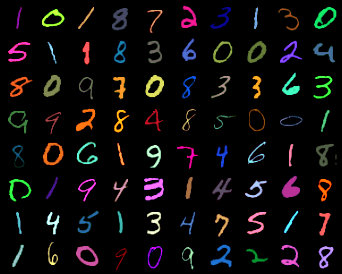

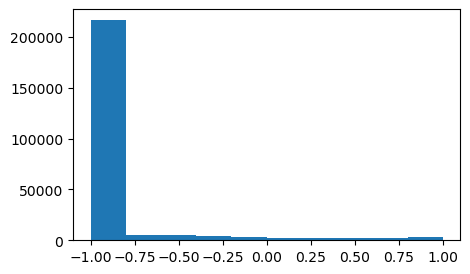

In [20]:
data_loader = torch.utils.data.DataLoader(train_dataset[-1], batch_size=80, shuffle=True)
for x, y in data_loader:
    # plt.hist(x.flatten().numpy())
    show_sample(x); break

In [16]:
global_model, private_modules = load_fedgan_all_styles(global_model, model_paths[-1], device=device)
[m["id"] for m in private_modules]

[0, 1, 2, 3]

In [17]:
# Repeat labels each row
num_rows = 4
num_samples = num_rows * num_classes
label = torch.Tensor(range(10)).repeat(num_rows).to(device).int()

# Show a sample

### Different content different style per client

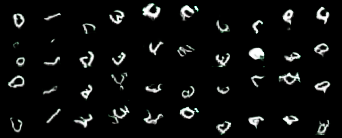

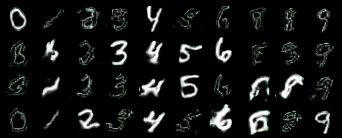

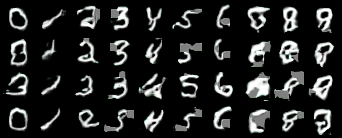

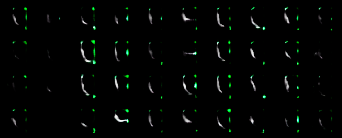

In [23]:
content_latent = torch.randn(num_samples, global_model.num_latents).to(device)
style_latent = torch.randn(num_samples, global_model.num_latents).to(device)

with torch.no_grad():
    for m in private_modules:
        style = m["style_map"](style_latent)
        fake = global_model.G(content_latent, cond=style, label=label)
        im = show_sample(fake)
        # im.save(f"results/w{m['id']:02d}{'_unseen' if unseen else ''}{'_cond' if conditional else ''}_diffcontent_diffstyle.pdf")

Colored MNIST need private batchnorms

### Same content different style per client

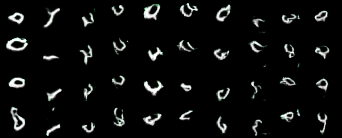

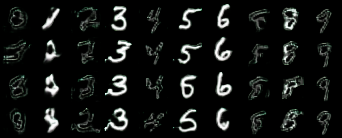

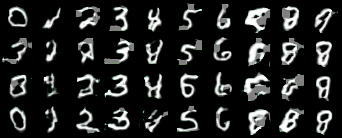

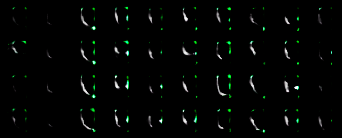

In [25]:
content_latent = torch.randn(num_samples, global_model.num_latents).to(device)
style_latent = torch.randn(num_samples//num_rows, global_model.num_latents).repeat(num_rows, 1).to(device)

with torch.no_grad():
    for m in private_modules:
        style = m["style_map"](style_latent)
        fake = global_model.G(content_latent, cond=style, label=label)
        im = show_sample(fake)
        # im.save(f"results/w{m['id']:02d}{'_unseen' if unseen else ''}{'_cond' if conditional else ''}_samecontent_diffstyle.pdf")

### Different content different style per client

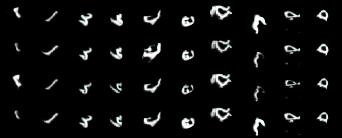

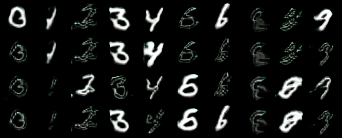

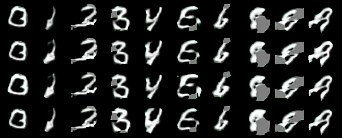

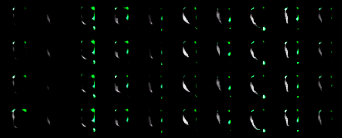

In [29]:
content_latent = torch.randn(num_samples//num_rows, global_model.num_latents).repeat(num_rows, 1).to(device)
style_latent = torch.randn(num_samples, global_model.num_latents).to(device)

with torch.no_grad():
    for m in private_modules:
        style = m["style_map"](style_latent)
        fake = global_model.G(content_latent, cond=style, label=label)
        im = show_sample(fake)
        # im.save(f"results/w{m['id']:02d}{'_unseen' if unseen else ''}{'_cond' if conditional else ''}_diffcontent_samestyle.pdf")

# Interpolation

In [30]:
import torch.nn.functional as F

def interpolate(real, fake, eps=None):
    if eps is None:
        eps_size = [1] * len(real.size())
        eps_size[0] = real.size(0)
        eps = torch.rand(eps_size).to(real)
    return eps * real + (1 - eps) * fake
    
def lerp(x1, x2, t=None):
    return interpolate(x1, x2, t)

def slerp(x1, x2, t=None):
    if t is None:
        t = torch.rand(x1.size(0)).to(x1)
    omega = torch.acos((F.normalize(x1)*F.normalize(x2)).sum(1))
    so = torch.sin(omega)
    res = (torch.sin((1.-t)*omega) / so).unsqueeze(1) * x1 \
        + (torch.sin(t*omega) / so).unsqueeze(1) * x2
    return res


In [31]:
def nice_vid_sample(num_rows, fname=None):
    # sample global latent and keep style same for all workers and show results
    N = num_rows * num_classes
    label = torch.Tensor(range(10)).repeat(num_rows).to(device).int()
    content_latent1 = torch.randn(N, global_model.num_latents).to(device)
    content_latent2 = torch.randn(N, global_model.num_latents).to(device)
    style_latent1 = torch.randn(N, global_model.num_latents).to(device)
    style_latent2 = torch.randn(N, global_model.num_latents).to(device)
    

    frames = []
    ts = list(torch.linspace(0,1,21))

    # Forward global_latent
    for t in ts:
        with torch.no_grad():
            content_latent = slerp(content_latent1, content_latent2, t)
            style_latent = style_latent1
            fake = global_model.G(content_latent, cond=global_model.style_map(style_latent), label=label)
        frames.append(gan_utils.make_grid(0.5 * fake + 0.5, nrow=num_classes, padding=2))
    # Backward global_latent
    for t in ts[::-1]:
        with torch.no_grad():
            content_latent = slerp(content_latent1, content_latent2, t)
            style_latent = style_latent1
            fake = global_model.G(content_latent, cond=global_model.style_map(style_latent), label=label)
        frames.append(gan_utils.make_grid(0.5 * fake + 0.5, nrow=num_classes, padding=2))

    # Forward style_latent
    for t in ts:
        with torch.no_grad():
            content_latent = content_latent1
            style_latent = slerp(style_latent1, style_latent2, t)
            fake = global_model.G(content_latent, cond=global_model.style_map(style_latent), label=label)
        frames.append(gan_utils.make_grid(0.5 * fake + 0.5, nrow=num_classes, padding=2))
    # Backward style_latent
    for t in ts[::-1]:
        with torch.no_grad():
            content_latent = content_latent1
            style_latent = slerp(style_latent1, style_latent2, t)
            fake = global_model.G(content_latent, cond=global_model.style_map(style_latent), label=label)
        frames.append(gan_utils.make_grid(0.5 * fake + 0.5, nrow=num_classes, padding=2))

    # Forward global_latent + style_latent
    for t in ts:
        with torch.no_grad():
            content_latent = slerp(content_latent1, content_latent2, t)
            style_latent = slerp(style_latent1, style_latent2, t)
            fake = global_model.G(content_latent, cond=global_model.style_map(style_latent), label=label)
        frames.append(gan_utils.make_grid(0.5 * fake + 0.5, nrow=num_classes, padding=2))
    # Backward global_latent + style_latent
    for t in ts[::-1]:
        with torch.no_grad():
            content_latent = slerp(content_latent1, content_latent2, t)
            style_latent = slerp(style_latent1, style_latent2, t)
            fake = global_model.G(content_latent, cond=global_model.style_map(style_latent), label=label)
        frames.append(gan_utils.make_grid(0.5 * fake + 0.5, nrow=num_classes, padding=2))

    # Make video
    if fname is not None:
        gan_utils.make_animation(frames, fname)

    return frames


for m in private_modules:
    print(f"Making video for client {m['id']}...")
    global_model.style_map = m["style_map"]
    nice_vid_sample(8, fname=f"results/w{m['id']:02d}{'_unseen' if unseen else ''}{'_cond' if conditional else ''}_vid.mp4")

Making video for client 0...


[2022-11-18 14:45:46] (3947132) {animation.py:1050}INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
[2022-11-18 14:45:46] (3947132) {animation.py:328}INFO - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 800x800 -pix_fmt rgba -r 5.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y results/w00_unseen_cond_vid.mp4


Making video for client 1...


[2022-11-18 14:46:03] (3947132) {animation.py:1050}INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
[2022-11-18 14:46:03] (3947132) {animation.py:328}INFO - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 800x800 -pix_fmt rgba -r 5.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y results/w01_unseen_cond_vid.mp4


Making video for client 2...


[2022-11-18 14:46:21] (3947132) {animation.py:1050}INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
[2022-11-18 14:46:21] (3947132) {animation.py:328}INFO - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 800x800 -pix_fmt rgba -r 5.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y results/w02_unseen_cond_vid.mp4


Making video for client 3...


[2022-11-18 14:46:39] (3947132) {animation.py:1050}INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
[2022-11-18 14:46:39] (3947132) {animation.py:328}INFO - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 800x800 -pix_fmt rgba -r 5.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y results/w03_unseen_cond_vid.mp4
